### Problem 

The task is to predict the energy usage of a house based on Internet of Things (IoT) measurements of temperature, humidity, and weather observations. 

### Relevant Paper

Data driven prediction models of energy use of appliances in a low-energy house. Luis M. Candanedo, Véronique Feldheim, Dominique Deramaix. Energy and Buildings, Volume 140, 1 April 2017, Pages 81-97, ISSN 0378-7788, http://dx.doi.org/10.1016/j.enbuild.2017.01.083.

### Data Source

The authors provide their code and data in a [Github Repository](https://github.com/LuisM78/Appliances-energy-prediction-data)

The repository contains the complete data (energydata_complete.csv) as well as the training and testing splits used in the paper.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE, RFECV

## Reading Data

In [3]:
complete_data = pd.read_csv('appliances-energy-prediction-data/energydata_complete.csv')
train_data = pd.read_csv('appliances-energy-prediction-data/training.csv')
test_data = pd.read_csv('appliances-energy-prediction-data/testing.csv')
print("complete_data shape: ", complete_data.shape)
print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

complete_data shape:  (19735, 29)
train_data shape:  (14803, 32)
test_data shape:  (4932, 32)


In [4]:
# checking head of training data
print(train_data.head())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
4  2016-01-11 17:50:00          50      40  19.89  46.026667  19.2  44.500000   

      T3       RH_3         T4  ...  Press_mm_hg  RH_out  Windspeed  \
0  19.79  44.730000  19.000000  ...        733.5    92.0   7.000000   
1  19.79  44.790000  19.000000  ...        733.6    92.0   6.666667   
2  19.79  44.933333  18.926667  ...        733.7    92.0   6.333333   
3  19.79  45.000000  18.890000  ...        733.9    92.0   5.666667   
4  19.79  44.933333  18.890000  ...        734.0    92.0   5.333333   

   Visibility  Tdewpoint        rv1        rv2    NSM  WeekStatus  Day_of_week  
0   6

In [5]:
print(set(train_data['WeekStatus']))

{'Weekend', 'Weekday'}


In [6]:
print(set(train_data['Day_of_week']))

{'Friday', 'Thursday', 'Tuesday', 'Saturday', 'Wednesday', 'Monday', 'Sunday'}


In [7]:
# Data preparation for modeling
complete_data.index = pd.to_datetime(complete_data['date'])
train_data.index = pd.to_datetime(train_data['date'])
test_data.index = pd.to_datetime(test_data['date'])
train_data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


### Converting 'Day_of_week' from 'string' to 'Numbers'

In [8]:
train_data['Day_of_week'] = train_data.index.weekday
test_data['Day_of_week'] = test_data.index.weekday
train_data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,0
2016-01-11 17:10:00,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,0
2016-01-11 17:20:00,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,0
2016-01-11 17:40:00,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,0
2016-01-11 17:50:00,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,0


In [9]:
set(train_data['Day_of_week'])

{0, 1, 2, 3, 4, 5, 6}

### Converting WeekStatus from 'string' to 'Numbers' using get_dummies

In [10]:
# Changing 'Weekstatus'
train_data['WeekStatus'] = pd.get_dummies(train_data['WeekStatus'])
test_data['WeekStatus'] = pd.get_dummies(test_data['WeekStatus'])
train_data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,1,0
2016-01-11 17:10:00,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,1,0
2016-01-11 17:20:00,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,1,0
2016-01-11 17:40:00,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,1,0
2016-01-11 17:50:00,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,1,0


In [11]:
set(train_data['WeekStatus'])

{0, 1}

### Split the data into train data and train label, test data and test label

In [12]:
# data split
X_train = train_data.drop(['Appliances', 'date'], axis=1)
y_train = train_data['Appliances']
X_test = test_data.drop(['Appliances', 'date'], axis=1)
y_test = test_data['Appliances']
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (14803, 30)
y_train shape:  (14803,)
X_test shape:  (4932, 30)
y_test shape:  (4932,)


In [13]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluation metrics on test data

In [14]:
y_test_pred = lr_model.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_test_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R^2: ", r2_score(y_test, y_test_pred))
print("MAE: ", mean_absolute_error(y_test, y_test_pred))

MSE:  8753.524114632068
RMSE:  93.56026995809742
R^2:  0.15206399952829996
MAE:  52.05948877222465


### Evaluation metrics on train data

In [15]:
y_train_pred = lr_model.predict(X_train)
print("MSE: ", mean_squared_error(y_train, y_train_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R^2: ", r2_score(y_train, y_train_pred))
print("MAE: ", mean_absolute_error(y_train, y_train_pred))

MSE:  8741.215155469987
RMSE:  93.49446590825569
R^2:  0.17324237562457778
MAE:  53.238956424690556


### Checking the impact of number of features

In [16]:
RMSE_list = []
for i in range(1, 30):
    model = linear_model.LinearRegression()
    selector = RFE(model, i)
    selector.fit(X_train, y_train)
    y_predicted_test = selector.predict(X_test)
    RMSE_list.append(np.sqrt(mean_squared_error(y_test, y_predicted_test)))

Text(0, 0.5, 'RMSE')

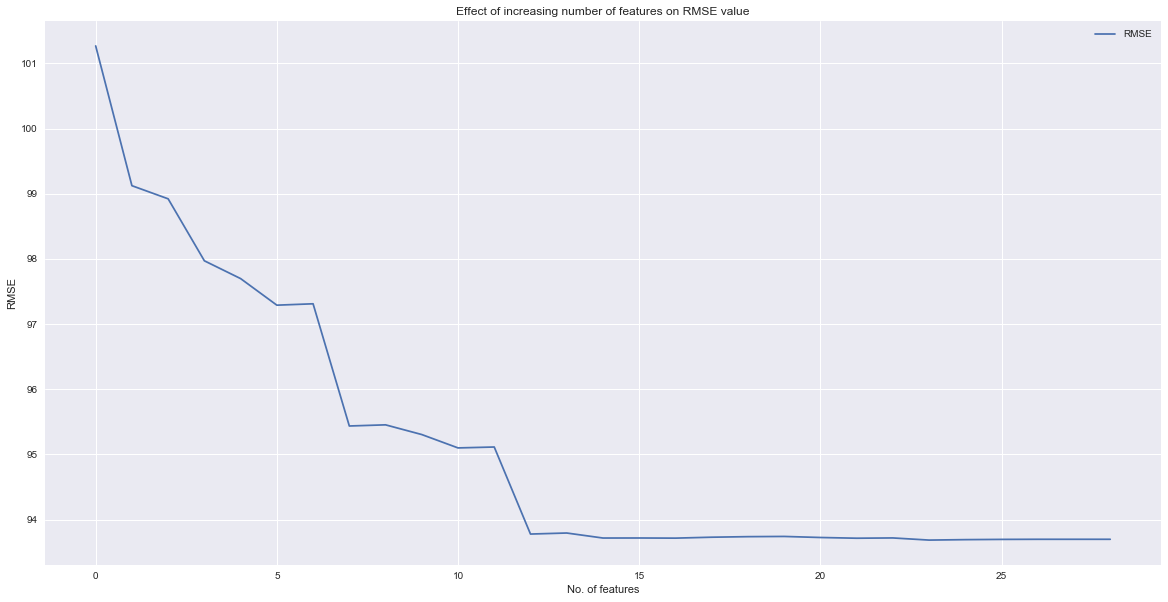

In [17]:
# Plot
RMSE_df = pd.DataFrame(RMSE_list, columns=['RMSE'])
plt.figure(figsize=(20,10))
sns.lineplot(data=RMSE_df)
plt.title('Effect of increasing number of features on RMSE value')
plt.xlabel('No. of features')
plt.ylabel('RMSE')

### Finding most important features

In [18]:
model = linear_model.LinearRegression()
top_15 = 15
selector = RFE(model, top_15)
selector.fit(X_train, y_train)
y_predicted_test = selector.predict(X_test)
support_var = selector.get_support()
print("Top 15 important features: ", X_train.columns[support_var])

Top 15 important features:  Index(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'T6', 'T8',
       'RH_8', 'T9', 'T_out', 'Windspeed', 'WeekStatus'],
      dtype='object')
